Based on NDA results:
https://github.com/techn0man1ac/ToxicCommentClassification/tree/main/Data_science

In [2]:
import numpy as np
import pandas as pd
import optuna
#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = '/Users/alexandr/Desktop/BERT/train.csv'
test ='/Users/alexandr/Desktop/BERT/test.csv'
sample_subbmission = '/Users/alexandr/Desktop/BERT/sample_submission.csv'
test_labels = '/Users/alexandr/Desktop/BERT/test_labels.csv'

In [4]:
train_data = pd.read_csv(train)
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
test_values = pd.read_csv(test)
#test_values = test_values['comment_text'].tolist()
test_values

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [6]:
test_labels = pd.read_csv(test_labels)
print(test_labels.shape)
test_labels = test_labels[
    (test_labels["toxic"] != -1) &
    (test_labels["severe_toxic"] != -1) &
    (test_labels["obscene"] != -1) &
    (test_labels["threat"] != -1) &
    (test_labels["insult"] != -1) &
    (test_labels["identity_hate"] != -1)
]

test_labels.shape

(153164, 7)


(63978, 7)

In [7]:
#assert len() == len(test_labels), "length do not equal"

In [8]:
test_data = pd.merge(test_values, test_labels, on = "id" )
test_data.shape


(63978, 8)

In [9]:
test_texts = test_data['comment_text']
test_labels = test_data.iloc[:, 2:]

In [10]:
#data = pd.read_csv(sample_subbmission)
#data.head()

In [11]:
#data = pd.read_csv(test_labels)
#data.head(10)

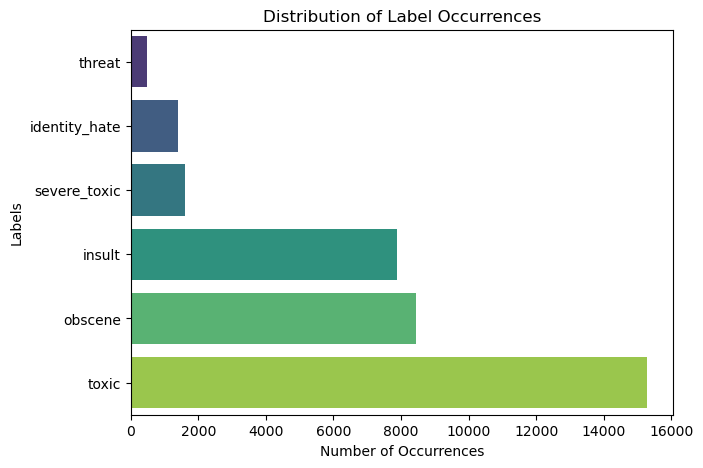

In [12]:
# Visualizing the class distribution of the 'label' column 
column_labels = train_data.columns.tolist()[2:] 
label_counts = train_data[column_labels].sum().sort_values() 


# Create a black background for the plot 
plt.figure(figsize=(7, 5)) 

# Create a horizontal bar plot using Seaborn 
ax = sns.barplot(x=label_counts.values, 
				y=label_counts.index, palette='viridis') 


# Add labels and title to the plot 
plt.xlabel('Number of Occurrences') 
plt.ylabel('Labels') 
plt.title('Distribution of Label Occurrences') 

# Show the plot 
plt.show() 



In [13]:
train_data[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

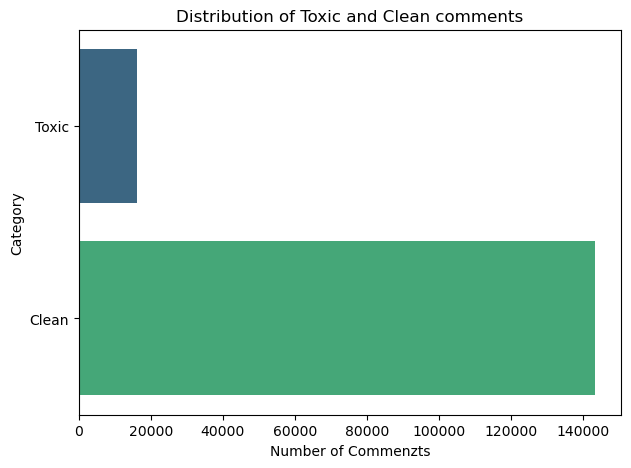

In [14]:
# Create subsets based on toxic and clean comments 
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create DataFrame for visualisation
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize = (7,5))

# Horizontal BAR
ax = sns.barplot(x = 'Count', y = 'Category', data = plot_data, palette = 'viridis')

plt.xlabel('Number of Commenzts')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean comments')

ax.tick_params()
plt.show()


In [15]:
print(train_toxic.shape) 
print(train_clean.shape)

(16225, 8)
(143346, 8)


In [16]:
from sklearn.utils import resample
import pandas as pd

# Максимальное количество примеров для любого класса
max_class_count = train_data[column_labels].sum(axis=0).max()

augmented_dataframes = []

# Шаг 1. Аугментация одиночных классов
for label in ["threat", "identity_hate", "severe_toxic", "insult", "obscene", "toxic"]:
    # Выбираем строки, где только данный класс равен 1
    single_class_data = train_data[(train_data[label] == 1) & (train_data[column_labels].sum(axis=1) == 1)]
    if single_class_data.empty:
        print(f"No single-class data available for label: {label}")
        single_class_data = train_data[train_data[label] == 1]
    oversampled_class = resample(single_class_data, replace=True, n_samples=max_class_count, random_state=42)
    augmented_dataframes.append(oversampled_class)

# Шаг 2. Добавление смешанных классов
# Выбираем строки, где текст относится к нескольким классам
train_toxic_mixed_classes = train_data[train_data[column_labels].sum(axis=1) > 1]
augmented_dataframes.append(train_toxic_mixed_classes)

# Шаг 3. Объединяем все DataFrame
augmented_dataframes = pd.concat(augmented_dataframes, ignore_index=True)

# Шаг 4. Проверяем результат
print("Shape of augmented DataFrame:", augmented_dataframes.shape)
print("Class distribution after augmentation:")
print(augmented_dataframes[column_labels].sum())


No single-class data available for label: severe_toxic
Shape of augmented DataFrame: (101629, 8)
Class distribution after augmentation:
toxic            40216
severe_toxic     16889
obscene          38009
threat           16829
insult           36080
identity_hate    19744
dtype: int64


In [17]:
# Randomly sample 16225 clean comments 
train_clean_sampled = train_clean.sample(n=101629, random_state=42)

# Combine the toxic and the sampled clean comments
dataframe = pd.concat([augmented_dataframes, train_clean_sampled], axis = 0)

#Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state = 42)


In [21]:
# Formatted output
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_counts_augmented = dataframe[class_columns].sum()

# Analyzing comments with no labels
no_labels_count = (dataframe[class_columns].sum(axis=1) == 0).sum()

# Calculating percentage distribution
total_comments = class_counts_augmented.sum() + no_labels_count
class_percentages = class_counts_augmented / total_comments * 100
no_labels_percentage = no_labels_count / total_comments * 100
total_comments_percentage = total_comments / total_comments * 100

print("Distribution among augmented classes:")
print(f"{'Class':<15}{'Count':<15}{'Percentage':<10}")
print("-" * 40)
for label, count in class_counts_augmented.items():
    percentage = class_percentages[label]
    print(f"{label:<15}{count:<15}{percentage:<10.2f}%")
print(f"{'Non-toxic':<15}{no_labels_count:<15}{no_labels_percentage:<10.2f}%")
print(f"{'Total':<15}{total_comments:<15}{total_comments_percentage:<10.2f}%")

Distribution among augmented classes:
Class          Count          Percentage
----------------------------------------
toxic          40216          14.93     %
severe_toxic   16889          6.27      %
obscene        38009          14.11     %
threat         16829          6.25      %
insult         36080          13.39     %
identity_hate  19744          7.33      %
Non-toxic      101629         37.72     %
Total          269396         100.00    %


In [53]:
dataframe.shape

(203258, 8)

In [54]:
dataframe.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
128482,af29e818d6fda430,why you blocking when i am fixing the pages? \...,0,0,0,0,0,0
48752,aeef5331c4b038c4,"Waaaaahh erase comments on this page too, do y...",0,0,0,0,1,0
52283,ed2e96d40594fc79,ashley tisdale is a hippoh,0,0,0,0,1,0
107666,3f8b406a72eb55c7,THE GUYS WHO INTERESTED IN THE ARTICLE TO BE I...,0,0,0,0,0,0
156526,cf9192e9f9098db0,I do not believe you could find a single examp...,0,0,0,0,0,0


In [55]:
# split training data into training_texts, training_labels
train_texts = dataframe.iloc[:, 1] 
train_labels = dataframe.iloc[:, 2:]

In [56]:
print(test_data.isnull().sum())  # missing data in each collumn


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [57]:
print(test_data.iloc[:, 1].shape)  # Форма текстов
print(test_data.iloc[:, 2:].shape)  # Форма меток


(63978,)
(63978, 6)


In [58]:
# Validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,  # Тексты
    train_labels,  # Метки
    test_size=0.25,
    random_state=42
)

print(train_texts.shape)  # Количество текстов в тренировочной выборке
print(train_labels.shape)  # Метки для тренировочной выборки
print(val_texts.shape)  # Количество текстов в валидационной выборке
print(val_labels.shape)  # Метки для валидационной выборки


(152443,)
(152443, 6)
(50815,)
(50815, 6)


In [59]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128): 
    # Initialize empty lists to store tokenized inputs and attention masks 
    input_ids = [] 
    attention_masks = [] 

    # Iterate through each comment in the 'comments' list 
    for comment in comments: 
        # Tokenize and encode the comment using the BERT tokenizer 
        encoded_dict = tokenizer.encode_plus( 
            comment, 

            # Add special tokens like [CLS] and [SEP] 
            add_special_tokens=True, 

            # Truncate or pad the comment to 'max_length' 
            max_length=max_length, 

            truncation=True,

            # Pad the comment to 'max_length' with zeros if needed 
            pad_to_max_length=True, 

            # Return attention mask to mask padded tokens 
            return_attention_mask=True, 

            # Return PyTorch tensors 
            return_tensors='pt'
        ) 

        # Append the tokenized input and attention mask to their respective lists 
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask']) 

    # Concatenate the tokenized inputs and attention masks into tensors 
    input_ids = torch.cat(input_ids, dim=0) 
    attention_masks = torch.cat(attention_masks, dim=0) 

    # Convert the labels to a PyTorch tensor with the data type float32
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.float32) 
        
    return input_ids, attention_masks, labels


   

In [60]:
# Token initialisation bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True) 

In [61]:
# Model initialisation
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 

In [62]:
# Model initialisation roberta-base
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#tokenizer = AutoTokenizer.from_pretrained("roberta-base")
#model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=6)

In [63]:
# Model initialisation distilbert-base-uncased
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

In [64]:
# Define the device (MPS for macOS or CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Move model to the device
#model = model.to(device) 


Using device: mps


In [65]:
print(type(train_labels))
print(type(test_labels))
#val_labels = val_labels.to_numpy()
print(type(val_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [66]:
# Tokenize and Encode the comments and labels for the training set 
input_ids, attention_masks, labels_tr = tokenize_and_encode( 
	tokenizer, 
	train_texts, 
	train_labels.values 
) 
print('Training Comments :',train_texts.shape) 
print('Input Ids		 :',input_ids.shape) 
print('Attention Mask :',attention_masks.shape) 
print('Labels		 :',len(labels_tr))



# Tokenize and Encode the comments and labels for the test set 
test_input_ids, test_attention_masks, labels_test = tokenize_and_encode( 
	tokenizer, 
	test_texts,
    test_labels.values
) 
print()
print('Test Comments :',test_texts.shape) 
print('Input Ids		 :',test_input_ids.shape) 
print('Attention Mask :',test_attention_masks.shape) 
print('Labels		 :',len(labels_test))



# Tokenize and Encode the comments and labels for the validation set 
val_input_ids, val_attention_masks, labels_val = tokenize_and_encode( 
	tokenizer, 
	val_texts, 
	val_labels.values
)
print()
print('Validation Comments :',val_texts.shape) 
print('Input Ids		 :',val_input_ids.shape) 
print('Attention Mask :',val_attention_masks.shape) 
print('Labels		 :', len(labels_val))

Training Comments : (152443,)
Input Ids		 : torch.Size([152443, 128])
Attention Mask : torch.Size([152443, 128])
Labels		 : 152443

Test Comments : (63978,)
Input Ids		 : torch.Size([63978, 128])
Attention Mask : torch.Size([63978, 128])
Labels		 : 63978

Validation Comments : (50815,)
Input Ids		 : torch.Size([50815, 128])
Attention Mask : torch.Size([50815, 128])
Labels		 : 50815


In [67]:
# Creating TensorDataset for the balanced dataset 
#batch_size = 64

train_dataset = TensorDataset(input_ids, attention_masks, labels_tr) 
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

# testing set 
test_dataset = TensorDataset(test_input_ids, test_attention_masks, labels_test) 
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, labels_val) 
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 


In [68]:
# Optimizer setup 
#optimizer = AdamW(model.parameters(), lr=1.11e-5)


In [69]:
class_counts = train_data[column_labels].sum(axis=0)  # Сумма для каждого класса
class_counts

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [70]:
import time
from torch.nn import BCEWithLogitsLoss

# Function to Train the Model
def train_model_with_params(model, train_loader, val_loader, optimizer, device, num_epochs, train_data, max_norm):
    start_time = time.time()

    # Compute class weights
    class_weights = train_data[column_labels].sum(axis=0)
    class_weights = class_weights / class_weights.max()
    class_weights = class_weights.clip(lower=0.5)
    class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)

    loss_fn = BCEWithLogitsLoss(pos_weight=class_weights_tensor)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels.float())
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels.float())
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')

    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")



In [71]:
# Define objective for Optuna
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = trial.suggest_int('num_epochs', 2, 5)
    max_norm = trial.suggest_float('max_norm', 0.5, 2.0)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_model_with_params(model, train_loader, val_loader, optimizer, device, num_epochs, train_data, max_norm)

    val_loss = 0
    model.eval()
    loss_fn = BCEWithLogitsLoss(pos_weight=torch.ones(6).to(device))

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_loss += loss_fn(logits, labels.float()).item()

    return val_loss / len(val_loader)


In [72]:
# use the study to find the best parameter
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Retrieve best parameters
best_params = study.best_params

# Use best parameters to create new loaders and train final model
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
num_epochs = best_params['num_epochs']
max_norm = best_params['max_norm']

# Create final DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize final model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Train and evaluate the final model
train_model_with_params(model, train_loader, val_loader, optimizer, device, num_epochs, train_data, max_norm)


[I 2025-01-02 20:04:46,693] A new study created in memory with name: no-name-c2a890a6-a63f-4074-a2f1-a45b2c9c02a9
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.06484411437214253, Validation Loss: 0.034755715680162315
Epoch 2, Train Loss: 0.027217978295475304, Validation Loss: 0.03129031314477813
Training time: 50566.96072602272 seconds


[I 2025-01-03 10:11:04,551] Trial 0 finished with value: 0.03700041769914225 and parameters: {'learning_rate': 1.0415375621124515e-05, 'batch_size': 16, 'num_epochs': 2, 'max_norm': 0.6193003569954709}. Best is trial 0 with value: 0.03700041769914225.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.0615446383667614, Validation Loss: 0.033440071843114094
Epoch 2, Train Loss: 0.02390594352005436, Validation Loss: 0.02834559930400496
Epoch 3, Train Loss: 0.015203599896345297, Validation Loss: 0.02620350899466874
Epoch 4, Train Loss: 0.010879814061342573, Validation Loss: 0.026479564039508744
Training time: 11289.23567891121 seconds


[I 2025-01-03 13:21:49,249] Trial 1 finished with value: 0.033539926674438676 and parameters: {'learning_rate': 4.2012953746454836e-05, 'batch_size': 64, 'num_epochs': 4, 'max_norm': 1.2767506186995536}. Best is trial 1 with value: 0.033539926674438676.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.06785886795052791, Validation Loss: 0.03477443679369592
Epoch 2, Train Loss: 0.026635157303145862, Validation Loss: 0.032635388204854884
Epoch 3, Train Loss: 0.01712625070751076, Validation Loss: 0.02455254531497287
Epoch 4, Train Loss: 0.011592678010167813, Validation Loss: 0.02834147325266903
Training time: 6693.530945062637 seconds


[I 2025-01-03 15:16:03,053] Trial 2 finished with value: 0.0339417904988822 and parameters: {'learning_rate': 1.364922977709337e-05, 'batch_size': 32, 'num_epochs': 4, 'max_norm': 1.48337857702278}. Best is trial 1 with value: 0.033539926674438676.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.05586604475845279, Validation Loss: 0.03582707985349894
Epoch 2, Train Loss: 0.024029904984658103, Validation Loss: 0.029123674188777756
Epoch 3, Train Loss: 0.015268788574397781, Validation Loss: 0.027202772961950922
Epoch 4, Train Loss: 0.011355151470978618, Validation Loss: 0.028689929262338952
Epoch 5, Train Loss: 0.008987916655244366, Validation Loss: 0.03319473529288626
Training time: 13363.297671079636 seconds


[I 2025-01-03 19:01:38,209] Trial 3 finished with value: 0.039966694066471416 and parameters: {'learning_rate': 2.46493504340541e-05, 'batch_size': 16, 'num_epochs': 5, 'max_norm': 1.5638782149121915}. Best is trial 1 with value: 0.033539926674438676.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.06379058793326722, Validation Loss: 0.03238402955572447
Epoch 2, Train Loss: 0.02490054050079591, Validation Loss: 0.025137770851934447
Epoch 3, Train Loss: 0.015354919957220776, Validation Loss: 0.02440899906029587
Epoch 4, Train Loss: 0.010741597964840926, Validation Loss: 0.027809053401170084
Training time: 6724.987931966782 seconds


[I 2025-01-03 20:56:23,242] Trial 4 finished with value: 0.034287839271104716 and parameters: {'learning_rate': 2.061260555235963e-05, 'batch_size': 32, 'num_epochs': 4, 'max_norm': 1.9979648210224727}. Best is trial 1 with value: 0.033539926674438676.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.08117327366671724, Validation Loss: 0.039113699770544276
Epoch 2, Train Loss: 0.029179647331861864, Validation Loss: 0.03025458196456068
Epoch 3, Train Loss: 0.018605060828106805, Validation Loss: 0.027950014272746945
Epoch 4, Train Loss: 0.012793893743745082, Validation Loss: 0.02864138527420849
Training time: 6345.277598142624 seconds


[I 2025-01-03 22:44:45,304] Trial 5 finished with value: 0.03484646507920944 and parameters: {'learning_rate': 1.4689710549080873e-05, 'batch_size': 64, 'num_epochs': 4, 'max_norm': 1.8236676531160045}. Best is trial 1 with value: 0.033539926674438676.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.05619110630698679, Validation Loss: 0.03305102797633891
Epoch 2, Train Loss: 0.024071559190416224, Validation Loss: 0.027251166406703962
Training time: 3347.6813740730286 seconds


[I 2025-01-03 23:43:12,989] Trial 6 finished with value: 0.03294129491590435 and parameters: {'learning_rate': 3.504254733842103e-05, 'batch_size': 32, 'num_epochs': 2, 'max_norm': 0.7141109391382372}. Best is trial 6 with value: 0.03294129491590435.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.07203071206832722, Validation Loss: 0.036889637022523174
Epoch 2, Train Loss: 0.027621104795321327, Validation Loss: 0.0288242271500059
Epoch 3, Train Loss: 0.017440666931068566, Validation Loss: 0.02712698922019278
Epoch 4, Train Loss: 0.011789333294266235, Validation Loss: 0.026847871303997035
Epoch 5, Train Loss: 0.0086677532291494, Validation Loss: 0.02955452451012392
Training time: 8364.849352836609 seconds


[I 2025-01-04 02:05:18,122] Trial 7 finished with value: 0.0369853393261268 and parameters: {'learning_rate': 1.2861748936147463e-05, 'batch_size': 32, 'num_epochs': 5, 'max_norm': 1.8150979901575768}. Best is trial 6 with value: 0.03294129491590435.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.0707534074808348, Validation Loss: 0.03449046935432213
Epoch 2, Train Loss: 0.02673228098745016, Validation Loss: 0.026688390931713345
Epoch 3, Train Loss: 0.01700142525482076, Validation Loss: 0.02898560030518835
Epoch 4, Train Loss: 0.011250638501746204, Validation Loss: 0.026670505486488704
Epoch 5, Train Loss: 0.008408934043199598, Validation Loss: 0.031642188823679494
Training time: 8364.666733026505 seconds


[I 2025-01-04 04:27:22,766] Trial 8 finished with value: 0.038364510848815904 and parameters: {'learning_rate': 1.3070558317078385e-05, 'batch_size': 32, 'num_epochs': 5, 'max_norm': 1.55940292974919}. Best is trial 6 with value: 0.03294129491590435.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.05594488567784271, Validation Loss: 0.03459639230079454
Epoch 2, Train Loss: 0.02767378487558097, Validation Loss: 0.02975930307297801
Training time: 3765.4716901779175 seconds


[I 2025-01-04 05:33:00,117] Trial 9 finished with value: 0.03878758566638829 and parameters: {'learning_rate': 4.335135293310142e-05, 'batch_size': 16, 'num_epochs': 2, 'max_norm': 1.054875044722676}. Best is trial 6 with value: 0.03294129491590435.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.056870627690720085, Validation Loss: 0.03526853993134772
Epoch 2, Train Loss: 0.024236192404373948, Validation Loss: 0.027168166525096
Training time: 3361.3310120105743 seconds


In [73]:
# Dirrectory for the model
model_save_path = "./saved_model_oversampling_with_optuna_correct_oversampling"

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


('./saved_model_oversampling_with_optuna_correct_oversampling/tokenizer_config.json',
 './saved_model_oversampling_with_optuna_correct_oversampling/special_tokens_map.json',
 './saved_model_oversampling_with_optuna_correct_oversampling/vocab.txt',
 './saved_model_oversampling_with_optuna_correct_oversampling/added_tokens.json')

In [128]:
# Load the tokenizer and model from the saved directory 
model_name = model_save_path
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name) 
Bert_Model = BertForSequenceClassification.from_pretrained( 
	model_name).to(device) 


In [75]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device): 
	user_input = [input_text] 

	user_encodings = tokenizer( 
		user_input, truncation=True, padding=True, return_tensors="pt") 

	user_dataset = TensorDataset( 
		user_encodings['input_ids'], user_encodings['attention_mask']) 

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False) 

	model.eval() 
	with torch.no_grad(): 
		for batch in user_loader: 
			input_ids, attention_mask = [t.to(device) for t in batch] 
			outputs = model(input_ids, attention_mask=attention_mask) 
			logits = outputs.logits 
			predictions = torch.sigmoid(logits) 

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int) 
	labels_list = ['toxic', 'severe_toxic', 'obscene', 
				'threat', 'insult', 'identity_hate'] 
	result = dict(zip(labels_list, predicted_labels[0])) 
	return result 





In [76]:
text = "You rock!"
predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 0,
 'identity_hate': 0}

In [ ]:
text = 'Are you insane!'

print(predict_user_input(input_text=text))


In [80]:
text = "Such an Idiot person"

predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [81]:
print(predict_user_input(input_text='How are you?'))

{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [ ]:
# Model evaluation on the validation data
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
model = Bert_Model  # Ensure this is defined elsewhere

def metrix_calculation(model, loader, device, save_conf_matrix=False, conf_matrix_path="./saved_model_oversampling_with_optuna_correct_oversampling/confusion_matrix.csv"):

    true_labels = [] 
    predicted_probs = [] 

    with torch.no_grad(): 
        for batch in loader: 
            input_ids, attention_mask, labels = [t.to(device) for t in batch] 

            # Get model's predictions 
            outputs = model(input_ids, attention_mask=attention_mask) 
            # Use sigmoid for multilabel classification 
            predicted_probs_batch = torch.sigmoid(outputs.logits) 
            predicted_probs.append(predicted_probs_batch.cpu().numpy()) 

            true_labels_batch = labels.cpu().numpy() 
            true_labels.append(true_labels_batch) 

    # Combine predictions and labels for evaluation 
    true_labels = np.concatenate(true_labels, axis=0) 
    predicted_probs = np.concatenate(predicted_probs, axis=0) 
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification 

    # Calculate evaluation metrics 
    accuracy = accuracy_score(true_labels, predicted_labels) 
    precision = precision_score(true_labels, predicted_labels, average='micro') 
    recall = recall_score(true_labels, predicted_labels, average='micro')
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels) 

    # Save confusion matrix to a CSV file if save_conf_matrix is True
    if save_conf_matrix:
        flattened_data = []
        for i, matrix in enumerate(conf_matrix):
            TN, FP = matrix[0]
            FN, TP = matrix[1]
            flattened_data.append({
                'Class': columns[i],
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP
            })

        conf_matrix_df = pd.DataFrame(flattened_data)
        conf_matrix_df.to_csv(conf_matrix_path, index=False)

    # Print the evaluation metrics 
    print(f'Accuracy: {accuracy:.2f}') 
    print(f'Precision: {precision:.2f}') 
    print(f'Recall: {recall:.2f}')
    print(f'Confusion Matrices for Each Class:')
    for i, matrix in enumerate(conf_matrix):
        print(f"Class {columns[i]}:\n{matrix}")

    # Display confusion matrices as plots
    for i, matrix in enumerate(conf_matrix):
        disp = ConfusionMatrixDisplay(
            confusion_matrix=matrix, 
            display_labels=[f'Not Class {columns[i]}', f'Class {columns[i]}']
        )
        disp.plot(cmap='Blues')

Accuracy: 0.9495
Precision: 0.9615
Recall: 0.9612
Confusion Matrices for Each Class:
Class toxic:
[[40150   565]
 [  406  9694]]
Class severe_toxic:
[[46097   451]
 [   35  4232]]
Class obscene:
[[41009   181]
 [  423  9202]]
Class threat:
[[46559    34]
 [   62  4160]]
Class insult:
[[41434   311]
 [  543  8527]]
Class identity_hate:
[[45958    78]
 [  163  4616]]


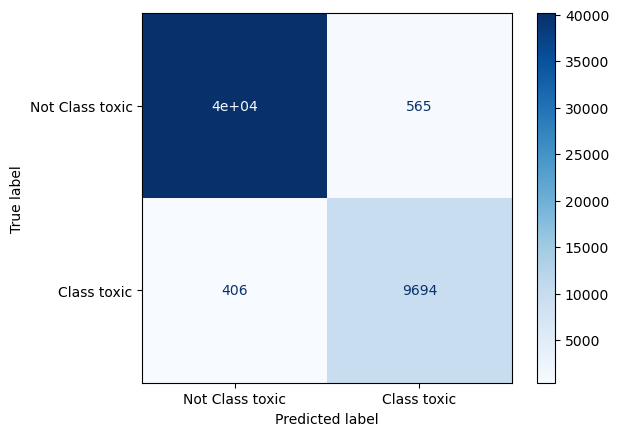

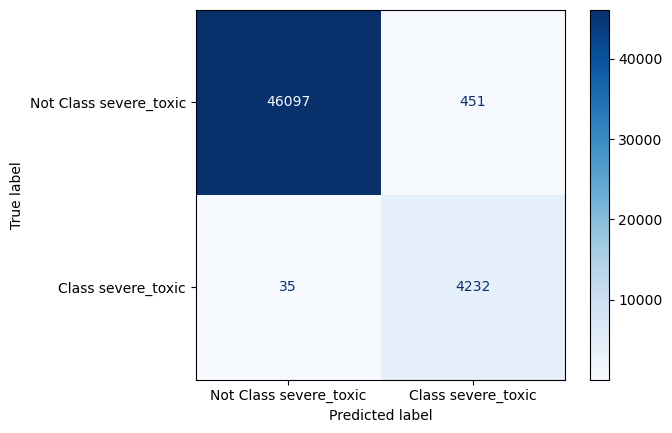

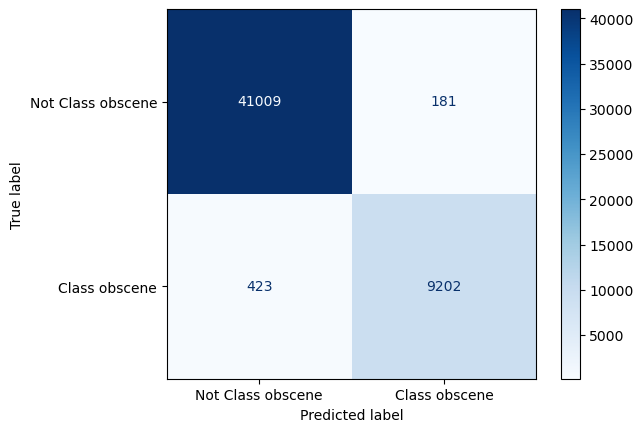

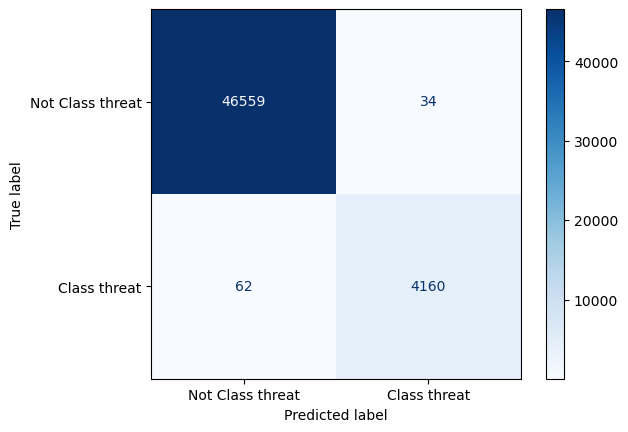

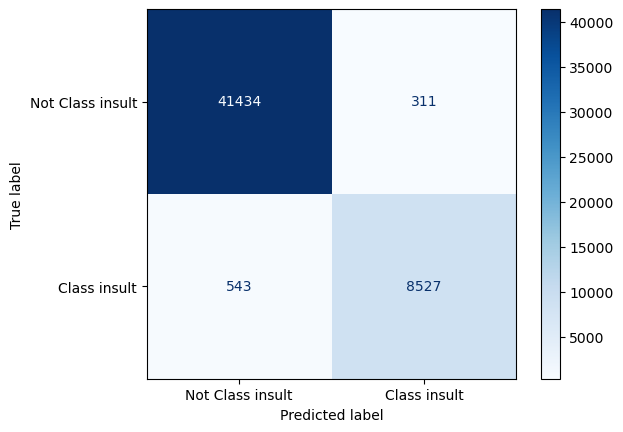

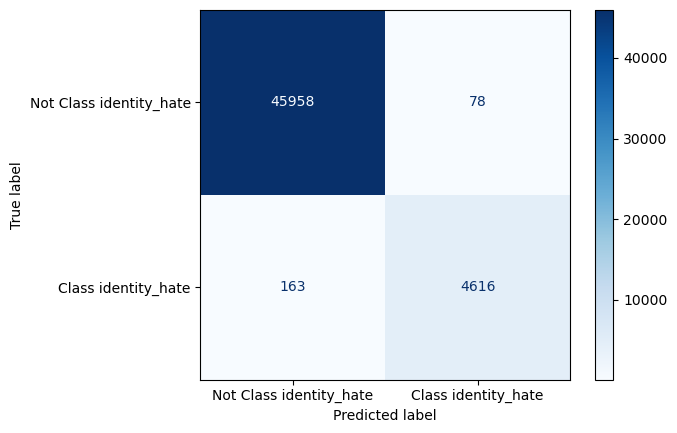

In [83]:
# Evaluate on val_loader and save the confusion matrix
metrix_calculation(model, val_loader, device, save_conf_matrix=True)

Accuracy: 0.8517
Precision: 0.5515
Recall: 0.7615
Confusion Matrices for Each Class:
Class toxic:
[[52581  5307]
 [  624  5466]]
Class severe_toxic:
[[62698   913]
 [   92   275]]
Class obscene:
[[58802  1485]
 [ 1014  2677]]
Class threat:
[[63700    67]
 [  105   106]]
Class insult:
[[59567   984]
 [ 1261  2166]]
Class identity_hate:
[[63045   221]
 [  362   350]]


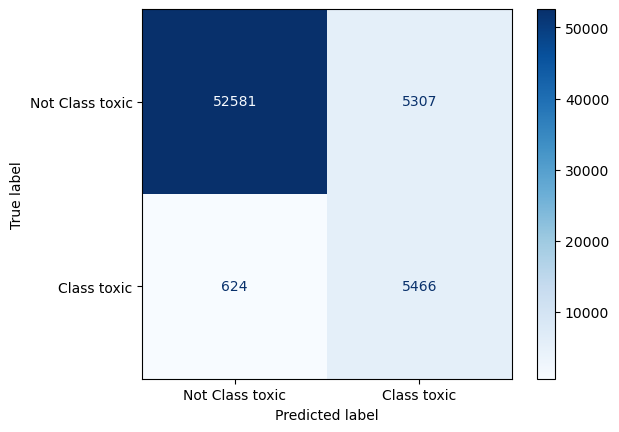

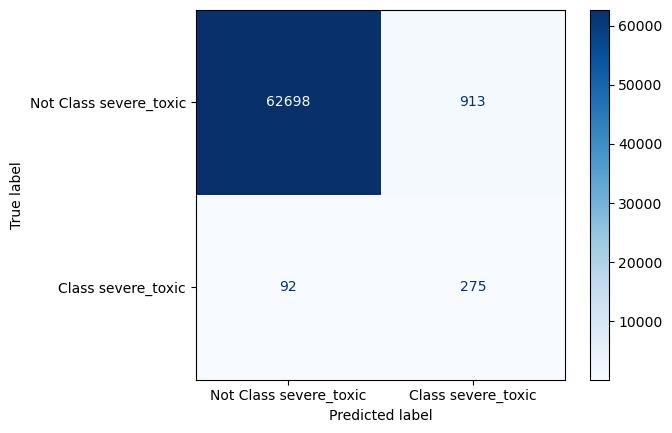

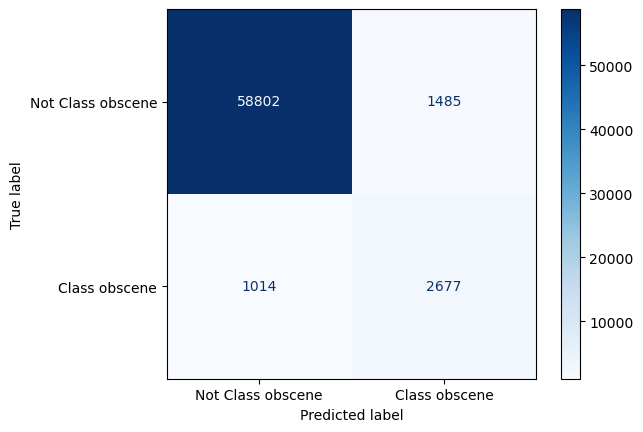

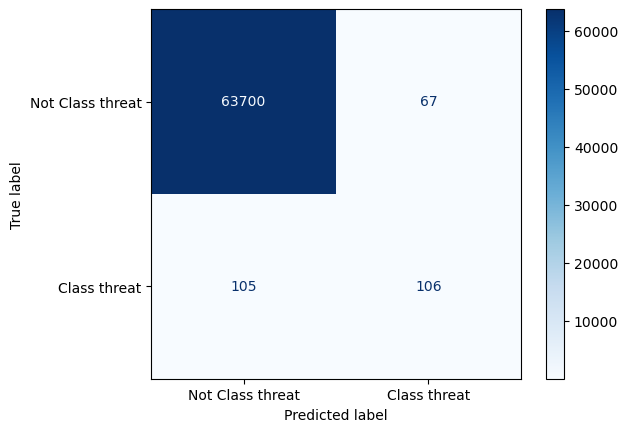

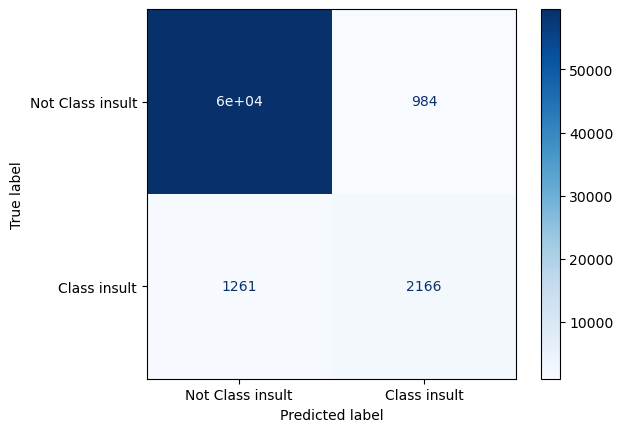

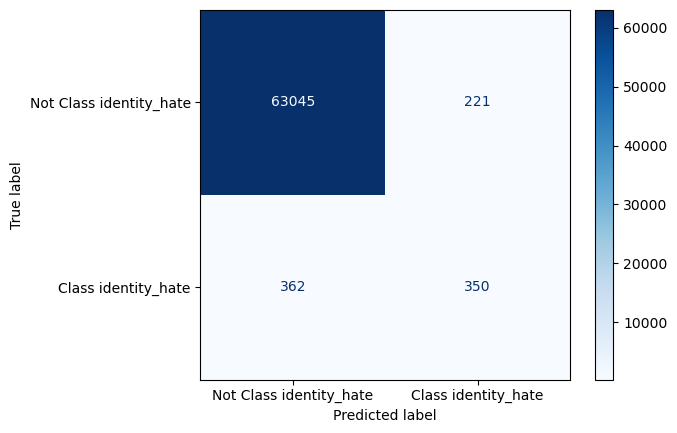

In [84]:
# Evaluate on test_loader without saving the confusion matrix
metrix_calculation(model, test_loader, device, save_conf_matrix=False)

In [85]:
#val_dataset(TensorDataset)
val_data = val_dataset.tensors # tuple from tensors
val_input_ids, val_attantion_mask, labels_val = map(lambda x: x.numpy(), val_data)
val_df = pd.DataFrame({
    "input_ids": val_input_ids.tolist(),
    "attantion_mask": val_attantion_mask.tolist(),
    "labels": labels_val.tolist()
})

val_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/val_dataset.csv", index = False)

In [86]:
val_labels[val_labels.columns].sum()

toxic            10100
severe_toxic      4267
obscene           9625
threat            4222
insult            9070
identity_hate     4779
dtype: int64

In [87]:
type(train_texts)

pandas.core.series.Series

In [89]:
# Преобразование текстов в DataFrame
train_texts_df = pd.DataFrame({"texts": train_texts})
val_texts_df = pd.DataFrame({"texts": val_texts})

# Проверка на тип меток
if not isinstance(train_labels, pd.DataFrame):
    raise ValueError("train_labels is not a DataFrame. Please ensure correct format.")

if not isinstance(val_labels, pd.DataFrame):
    raise ValueError("val_labels is not a DataFrame. Please ensure correct format.")

# Проверка сумм перед объединением
print("Sum of train_labels before concat:\n", train_labels.sum())
print("Sum of val_labels before concat:\n", val_labels.sum())

# Объединение текстов и меток
train_df = pd.concat([train_texts_df, train_labels], axis=1)
val_df = pd.concat([val_texts_df, val_labels], axis=1)

# Проверка сумм после объединения
print("Sum of train_df labels:\n", train_df[train_labels.columns].sum())
print("Sum of val_df labels:\n", val_df[val_labels.columns].sum())

# Сохранение в CSV
train_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/train_data.csv", index=False)
val_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/validation_data.csv", index=False)

Sum of train_labels before concat:
 toxic            30116
severe_toxic     12622
obscene          28384
threat           12607
insult           27010
identity_hate    14965
dtype: int64
Sum of val_labels before concat:
 toxic            10100
severe_toxic      4267
obscene           9625
threat            4222
insult            9070
identity_hate     4779
dtype: int64
Sum of train_df labels:
 toxic            30116
severe_toxic     12622
obscene          28384
threat           12607
insult           27010
identity_hate    14965
dtype: int64
Sum of val_df labels:
 toxic            10100
severe_toxic      4267
obscene           9625
threat            4222
insult            9070
identity_hate     4779
dtype: int64


In [90]:
                           #SECOND PART WITH CALCULATING THRESHOLDS






In [91]:
# Thresholds for evaluation on the validation data
from itertools import product
from sklearn.metrics import f1_score

threshold_grid = np.arange(0.1, 1.0, 0.1)  # Порог варьируется от 0.1 до 0.9 с шагом 0.1
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]  # Названия классов

# Получение true_labels и predicted_probs для валидационного набора
true_labels = []  # Сохраняем истинные метки
predicted_probs = []  # Сохраняем предсказанные вероятности

with torch.no_grad():
    for batch in val_loader:  # Валидационный DataLoader
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits)

        true_labels.append(labels.cpu().numpy())
        predicted_probs.append(probs.cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
predicted_probs = np.concatenate(predicted_probs, axis=0)

# Оптимизация порогов
best_thresholds = None
best_f1 = 0

for thresholds in product(threshold_grid, repeat=len(columns)):
    predicted_labels = (predicted_probs > np.array(thresholds)).astype(int)
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    if f1 > best_f1:
        best_f1 = f1
        best_thresholds = thresholds

print(f"Best Thresholds: {best_thresholds}, Best F1: {best_f1:.4f}")

Best Thresholds: (0.6, 0.9, 0.5, 0.8, 0.4, 0.5), Best F1: 0.9627


In [133]:
# Model evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
columns = ["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]
model=Bert_Model

def evaluate_model_with_thresholds(model, loader, device, thresholds, save_conf_matrix=False): 
    """
    Оценка модели с использованием адаптивных порогов для каждого класса.
    
    Args:
        model: Обученная модель (например, BERT).
        val_loader: DataLoader для валидационной выборки.
        device: Устройство для выполнения вычислений (CPU или GPU).
        thresholds: Список порогов для каждого класса.

    Returns:
        None. Выводит метрики Accuracy, Precision, Recall и матрицы ошибок для каждого класса.
    """
    model.eval()  # Устанавливаем модель в режим оценки

    true_labels = []  # Для хранения истинных меток
    predicted_probs = []  # Для хранения предсказанных вероятностей

    # Вычисления предсказаний модели
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in loader:  # Проходим по каждому батчу данных
            # Перенос данных на устройство
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            
            # Получаем предсказания модели
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Применяем сигмоиду для получения вероятностей
            
            # Сохраняем вероятности и истинные метки
            predicted_probs.append(predicted_probs_batch.cpu().numpy())
            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Объединяем вероятности и истинные метки в массивы
    true_labels = np.concatenate(true_labels, axis=0)  # Истинные метки
    predicted_probs = np.concatenate(predicted_probs, axis=0)  # Предсказанные вероятности
    
    # Применяем адаптивные пороги для предсказаний
    predicted_labels = (predicted_probs > np.array(thresholds)).astype(int)

    # Вычисляем метрики
    accuracy = accuracy_score(true_labels, predicted_labels)  # Точность (Accuracy)
    precision = precision_score(true_labels, predicted_labels, average='micro')  # Точность (Precision)
    recall = recall_score(true_labels, predicted_labels, average='micro')  # Полнота (Recall)
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)  # Матрицы ошибок для каждого класса

    # Now the metrics are accessible here
    metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Value": [accuracy, precision, recall]
    })
    metrics_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/metrics_2.csv", index=False)

    # Save confusion matrix to a CSV file if save_conf_matrix is True
    if save_conf_matrix:
        flattened_data = []
        for i, matrix in enumerate(conf_matrix):
            TN, FP = matrix[0]
            FN, TP = matrix[1]
            flattened_data.append({
                'Class': columns[i],
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP
            })

        conf_matrix_df = pd.DataFrame(flattened_data)
        conf_matrix_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/confusion_matrix_1.csv", index=False)

    # Выводим метрики
    print(f'Accuracy: {accuracy:.2f}') 
    print(f'Precision: {precision:.2f}') 
    print(f'Recall: {recall:.2f}')
    
    # Выводим матрицы ошибок для каждого класса
    for i, matrix in enumerate(conf_matrix):
        print(f"Class {columns[i]} Confusion Matrix:\n{matrix}")

    for i, matrix in enumerate(conf_matrix):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[f'Not Class {columns[i]}', f'Class {columns[i]}'])
        disp.plot(cmap='Blues')

    return accuracy, precision, recall

Accuracy: 0.95
Precision: 0.97
Recall: 0.96
Class toxic Confusion Matrix:
[[40216   499]
 [  459  9641]]
Class severe_toxic Confusion Matrix:
[[46328   220]
 [  176  4091]]
Class obscene Confusion Matrix:
[[41009   181]
 [  423  9202]]
Class threat Confusion Matrix:
[[46581    12]
 [   77  4145]]
Class insult Confusion Matrix:
[[41364   381]
 [  456  8614]]
Class identity_hate Confusion Matrix:
[[45958    78]
 [  163  4616]]


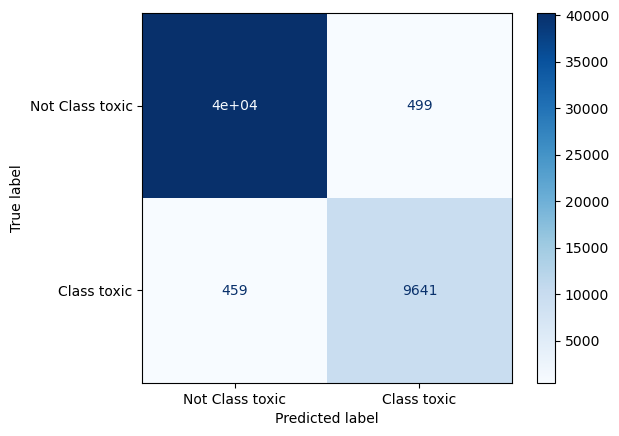

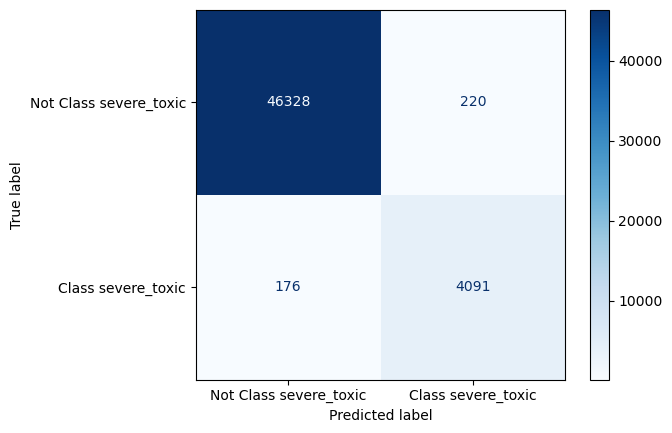

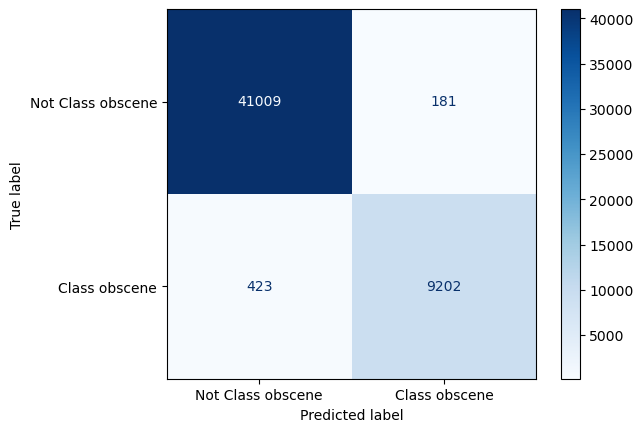

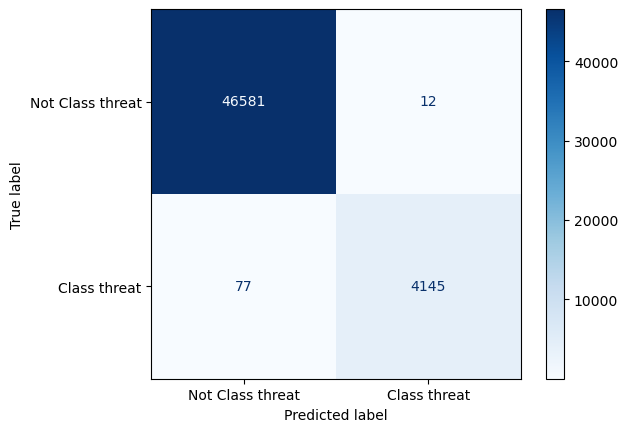

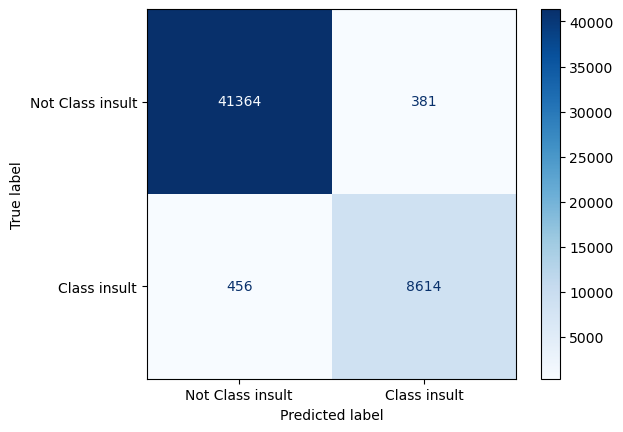

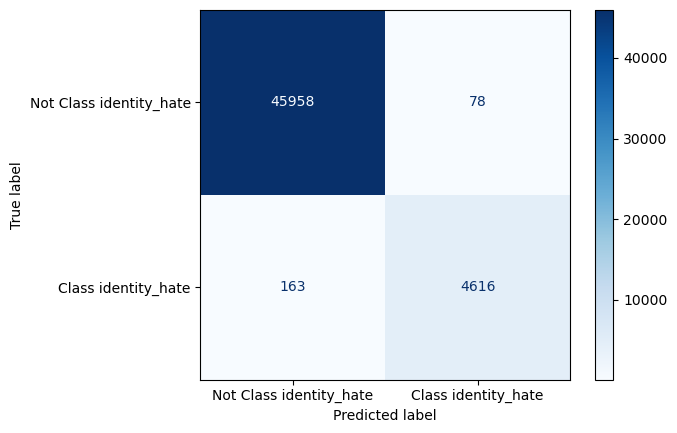

In [134]:
#accuracy, precision, recall = evaluate_model_with_thresholds(
#    model=model,
#    loader=val_loader,
#    device=device,
#    thresholds=best_thresholds,
#    save_conf_matrix=True
#)

# Now the metrics are accessible here
#metrics_df = pd.DataFrame({
#    "Metric": ["Accuracy", "Precision", "Recall"],
#    "Value": [accuracy, precision, recall]
#})
#metrics_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/metrics_2.csv", index=False)


In [108]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device, thresholds = best_thresholds): 
    """
    Делает предсказание для одного текста на основе указанных порогов.
    """
    user_input = [input_text] 
    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt") 
    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask']) 
    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False) 

    model.eval() 
    with torch.no_grad(): 
        for batch in user_loader: 
            input_ids, attention_mask = [t.to(device) for t in batch] 
            outputs = model(input_ids, attention_mask=attention_mask) 
            logits = outputs.logits 
            predictions = torch.sigmoid(logits) 

    predicted_labels = (predictions.cpu().numpy() > np.array(thresholds)).astype(int) 
    labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 
    result = dict(zip(labels_list, predicted_labels[0])) 
    return result


Accuracy: 0.95
Precision: 0.97
Recall: 0.96
Class toxic Confusion Matrix:
[[40216   499]
 [  459  9641]]
Class severe_toxic Confusion Matrix:
[[46328   220]
 [  176  4091]]
Class obscene Confusion Matrix:
[[41009   181]
 [  423  9202]]
Class threat Confusion Matrix:
[[46581    12]
 [   77  4145]]
Class insult Confusion Matrix:
[[41364   381]
 [  456  8614]]
Class identity_hate Confusion Matrix:
[[45958    78]
 [  163  4616]]


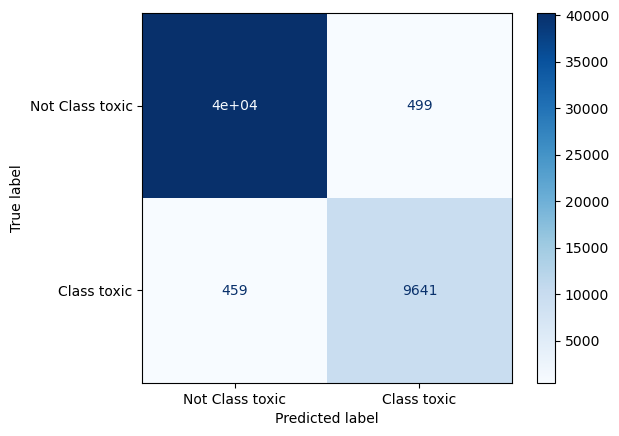

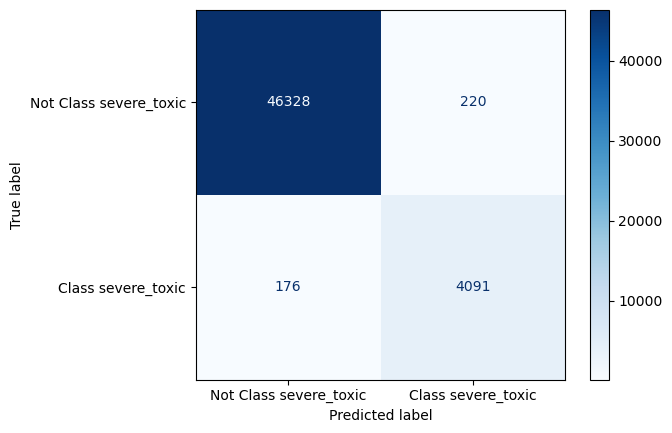

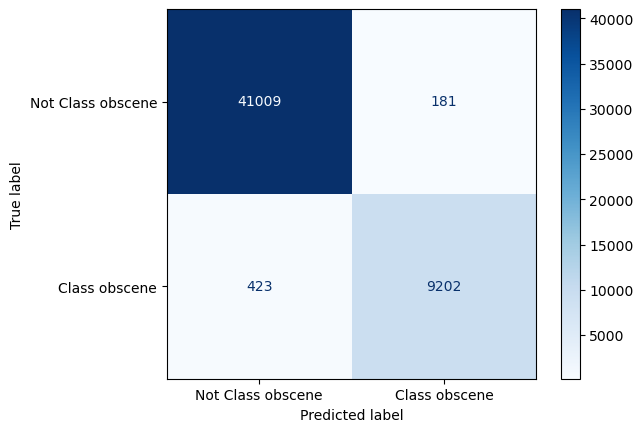

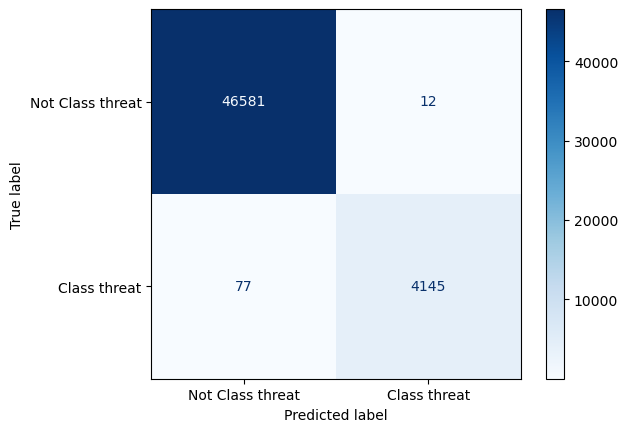

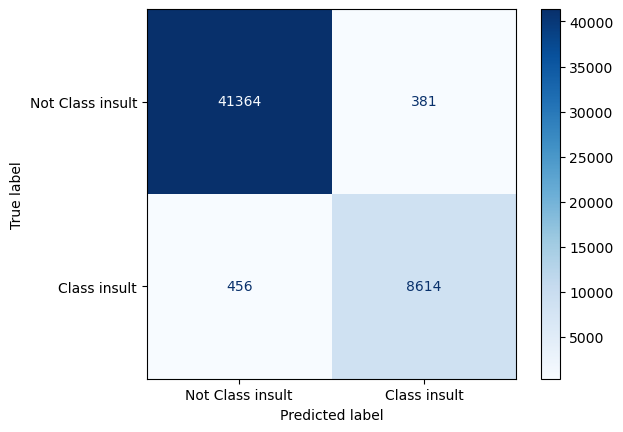

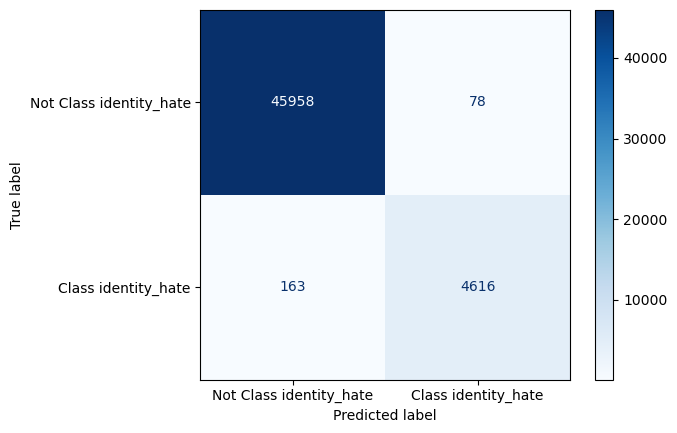

In [109]:
# Call the function to evaluate the model on the validation data 
evaluate_model_with_thresholds(model, val_loader, device, best_thresholds, save_conf_matrix=True)

Accuracy: 0.86
Precision: 0.57
Recall: 0.76
Class toxic Confusion Matrix:
[[52978  4910]
 [  705  5385]]
Class severe_toxic Confusion Matrix:
[[63149   462]
 [  172   195]]
Class obscene Confusion Matrix:
[[58802  1485]
 [ 1014  2677]]
Class threat Confusion Matrix:
[[63730    37]
 [  132    79]]
Class insult Confusion Matrix:
[[59336  1215]
 [ 1130  2297]]
Class identity_hate Confusion Matrix:
[[63045   221]
 [  362   350]]


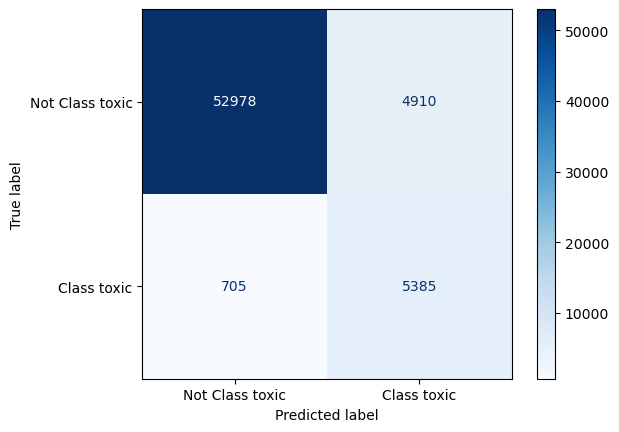

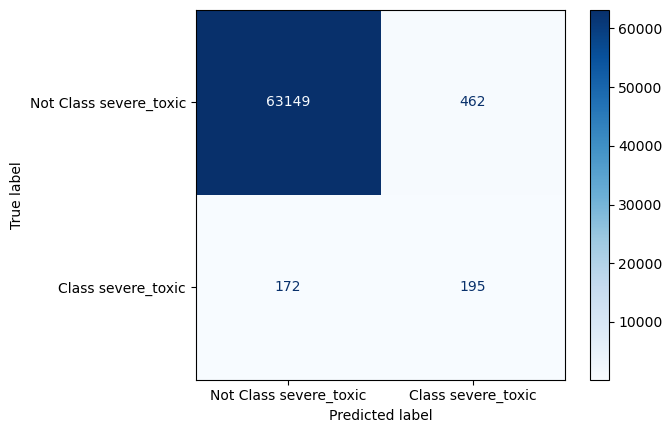

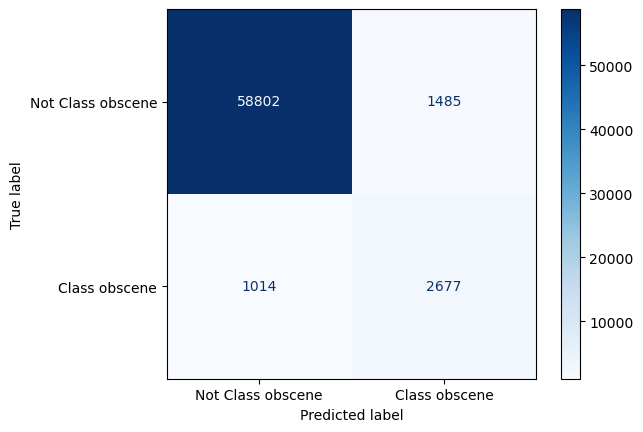

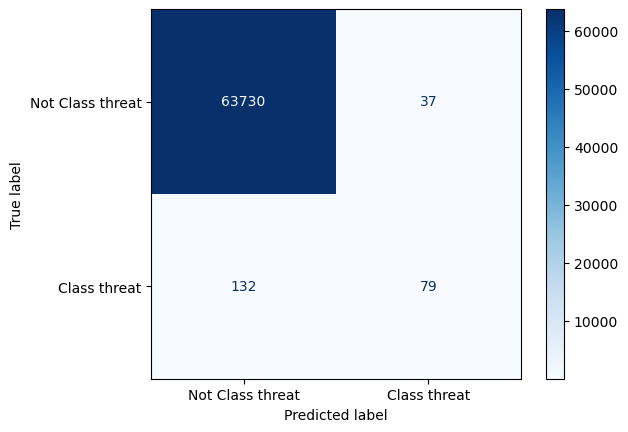

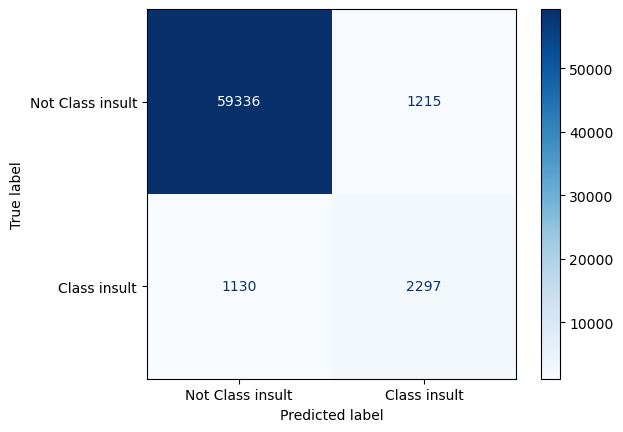

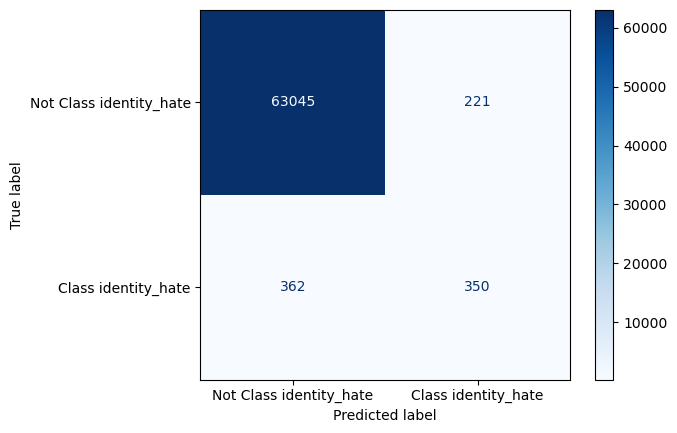

In [110]:
# Call the function to evaluate the model on the test data 
evaluate_model_with_thresholds(model, test_loader, device, best_thresholds, save_conf_matrix=False)

In [111]:
#val_dataset(TensorDataset)
val_data = val_dataset.tensors # tuple from tensors
val_input_ids, val_attantion_mask, labels_val = map(lambda x: x.numpy(), val_data)
val_df = pd.DataFrame({
    "input_ids": val_input_ids.tolist(),
    "attantion_mask": val_attantion_mask.tolist(),
    "labels": labels_val.tolist()
})

val_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/val_dataset_1.csv", index = False)

In [112]:
# Преобразование текстов в DataFrame
train_texts_df = pd.DataFrame({"texts": train_texts})
val_texts_df = pd.DataFrame({"texts": val_texts})

# Проверка на тип меток
if not isinstance(train_labels, pd.DataFrame):
    raise ValueError("train_labels is not a DataFrame. Please ensure correct format.")

if not isinstance(val_labels, pd.DataFrame):
    raise ValueError("val_labels is not a DataFrame. Please ensure correct format.")

# Проверка сумм перед объединением
print("Sum of train_labels before concat:\n", train_labels.sum())
print("Sum of val_labels before concat:\n", val_labels.sum())

# Объединение текстов и меток
train_df = pd.concat([train_texts_df, train_labels], axis=1)
val_df = pd.concat([val_texts_df, val_labels], axis=1)

# Проверка сумм после объединения
print("Sum of train_df labels:\n", train_df[train_labels.columns].sum())
print("Sum of val_df labels:\n", val_df[val_labels.columns].sum())

# Сохранение в CSV
train_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/train_data_1.csv", index=False)
val_df.to_csv("./saved_model_oversampling_with_optuna_correct_oversampling/validation_data_1.csv", index=False)

Sum of train_labels before concat:
 toxic            30116
severe_toxic     12622
obscene          28384
threat           12607
insult           27010
identity_hate    14965
dtype: int64
Sum of val_labels before concat:
 toxic            10100
severe_toxic      4267
obscene           9625
threat            4222
insult            9070
identity_hate     4779
dtype: int64
Sum of train_df labels:
 toxic            30116
severe_toxic     12622
obscene          28384
threat           12607
insult           27010
identity_hate    14965
dtype: int64
Sum of val_df labels:
 toxic            10100
severe_toxic      4267
obscene           9625
threat            4222
insult            9070
identity_hate     4779
dtype: int64


In [113]:
text = "You rock!"
predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 0,
 'identity_hate': 0}

In [114]:
text = 'Are you insane!'
#predict_user_input(input_text=text) 
print(predict_user_input(input_text=text) )

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 1, 'identity_hate': 0}


In [115]:
print(predict_user_input(input_text='How are you?'))


{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [116]:
text = "Such an Idiot person"
predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 


{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [ ]:
# Use best parameters to create new loaders and train final model

In [121]:
batch_size = best_params['batch_size']
batch_size

32

In [122]:
num_epochs = best_params['num_epochs']
num_epochs

2

In [123]:
max_norm = best_params['max_norm']
max_norm

0.7141109391382372

In [124]:
learning_rate = best_params['learning_rate']
learning_rate

3.504254733842103e-05